For this project an ANN will be implemented in a way that will allow the modification of hyper parameters to enhance the accuracy of the predictions.
This will be done with the use of many helper fuction and a main fuction that will load the data and call the helper functions to train the model.

In **version 0.1**** we will be using a 3 layers deep learning model where the activations for the  layers 1 through L-1 is a relu fuction with a sigmoid function for the last layer L and where we are using he initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import matplotlib.pyplot as plt #For plotting
from statistics import mean

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **======================= HERE STARTS HELPER METHODS ==========================**

In [2]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [3]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [4]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


In [5]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [6]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in the network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])  # Using he initialization
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))  
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [7]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples: 891)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples: 891)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [9]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1) from Layer 1 to Layer L-1 -> LINEAR->SIGMOID computation in Layer L
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1) from Layer 1 to Layer L-1. Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID in Layer L. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    """
    Implement the cost function

    Arguments:
    AL -- probability vector corresponding to the label predictions, shape (1, number of examples: 891)
    Y -- true "label" vector (for example: containing 0 if Did Not survive, 1 if survived), shape (1, number of examples: 891)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]
    
    # Compute loss from aL and y.
    log_Probs = (np.multiply(np.log(AL),Y)) + (np.multiply(np.log(1-AL),1-Y))
    cost = - np.sum(log_Probs)/m
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[18]] into 18).
    
    assert(cost.shape == ())
    
    return cost

In [11]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [12]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [13]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(grads["db" + str(l+1)])
    return parameters

**Below is a function for the whole model. It uses the previous implemented functions**

In [15]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost = False, print_plot = False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    # keep track of cost
    costs = []                         
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

        costs.append(cost)
    if print_plot:          
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [16]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == y)/m)
    
    #print results
    #print("Accuracy: "  + str(accuracy))
        
    return accuracy, p

In [17]:
def predict_for_test(X, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    return p

**Function to test best dimentions and learning rate combinations**

In [18]:
def evaluateHyper(inputLayer, evaluationIter,train_x, train_y):
    #Declaring and Initializing the best hyperparameters
    maxAccuracy = 0
    best_lamb = 0
    
    AvgAccuracy = 0
    accuracyList = []
    best_dim = []
    

    #Specifing the values that we need to try
    list_learning_Rate = [0.1, 0.3, 0.6, 0.9]
    list_Dim = [[inputLayer, 5 , 3, 1],[inputLayer, 4 , 1],[inputLayer, 3 , 1],[inputLayer, 2 , 1],[inputLayer, 1]] 

    #Going through each of the combination to figure out the cost fuction that is the most stable and accurate
    for lamb in list_learning_Rate:
        for dim in list_Dim:
            print(dim)
            for i in range(evaluationIter):
                parameters = L_layer_model(train_x, train_y, dim, learning_rate = lamb, num_iterations = 5000, print_cost = False, print_plot = False)
                accuracy, predictions = predict(train_x_np, train_y_np, parameters)
                accuracyList.append(accuracy)            
            # plot the cost
            plt.plot(np.squeeze(accuracyList))
            plt.ylabel('Accuracy')
            plt.xlabel('Iterations')
            plt.title("Learning rate =" + str(lamb) + "  Dimentions: " + str(dim))
            plt.show()
           
            if(mean(accuracyList) > AvgAccuracy):
                AvgAccuracy = mean(accuracyList)
                best_lamb = lamb
                best_dim = dim
            accuracyList = []

    print('maxAverageAccuracy: '+str(AvgAccuracy)+' best_lamb: '+str(best_lamb)+' best_dim: '+str(best_dim))



# **======================= THE DEEP NEURAL NETWORK ==========================**

**Loading training and testing data**

In [19]:
#Loading the train data into variables
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [20]:
#Loading the test data into variables
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


**Feature extraction, Cleaning, and normalizing**

In [21]:
#Loading feature data into train_x
features = ["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare", "Embarked"]
training_data = pd.get_dummies(train_data[features])

#normalizing the features
training_data["Age"] = training_data["Age"].divide(training_data["Age"].max())
training_data["Fare"] = training_data["Fare"].divide(training_data["Fare"].max())
training_data["Pclass"] = training_data["Pclass"].divide(training_data["Pclass"].max())

#Replacing NaN values with the median of the column
training_data['Pclass'].fillna(value = training_data['Pclass'].median(), inplace=True)
training_data['Age'].fillna(value = training_data['Age'].median(), inplace=True)
training_data['Sex_female'].fillna(value = training_data['Sex_female'].median(), inplace=True)
training_data['Sex_male'].fillna(value = training_data['Sex_male'].median(), inplace=True)
training_data['SibSp'].fillna(value = training_data['SibSp'].median(), inplace=True)
training_data['Parch'].fillna(value = training_data['Parch'].median(), inplace=True)
training_data['Fare'].fillna(value = training_data['Fare'].median(), inplace=True)

train_x = training_data.transpose()

#Converting the test data from a dataframe to a numpy array
train_x_np = train_x.to_numpy()
print(train_x_np)

train_x.head(100)



[[1.         0.33333333 1.         ... 1.         0.33333333 1.        ]
 [0.275      0.475      0.325      ... 0.35       0.325      0.4       ]
 [1.         1.         0.         ... 1.         0.         0.        ]
 ...
 [0.         1.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]]


,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
Pclass,1.000000,0.333333,1.000000,0.333333,1.000000,1.00000,0.333333,1.000000,1.000000,0.666667,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.666667,0.333333,1.000000,0.333333,1.000000
Age,0.275000,0.475000,0.325000,0.437500,0.437500,0.35000,0.675000,0.025000,0.337500,0.175000,...,0.412500,0.275000,0.350000,0.312500,0.487500,0.337500,0.237500,0.350000,0.325000,0.400000
SibSp,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,3.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Parch,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000
Fare,0.014151,0.139136,0.015469,0.103644,0.015713,0.01651,0.101229,0.041136,0.021731,0.058694,...,0.015412,0.020527,0.020495,0.013761,0.056848,0.025374,0.058556,0.045771,0.058556,0.015127
Sex_female,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
Sex_male,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Embarked_Q,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,1.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [22]:
#Loading feature data into test_x
features = ["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare", "Embarked"]
testing_data = pd.get_dummies(test_data[features])


#normalizing the features
testing_data["Age"] = testing_data["Age"].divide(testing_data["Age"].max())
testing_data["Fare"] = testing_data["Fare"].divide(testing_data["Fare"].max())
testing_data["Pclass"] = testing_data["Pclass"].divide(testing_data["Pclass"].max())

#Replacing NaN values with the median of the column
testing_data['Pclass'].fillna(value = testing_data['Pclass'].median(), inplace=True)
testing_data['Age'].fillna(value = testing_data['Age'].median(), inplace=True)
testing_data['Sex_female'].fillna(value = testing_data['Sex_female'].median(), inplace=True)
testing_data['Sex_male'].fillna(value = testing_data['Sex_male'].median(), inplace=True)
testing_data['SibSp'].fillna(value = testing_data['SibSp'].median(), inplace=True)
testing_data['Parch'].fillna(value = testing_data['Parch'].median(), inplace=True)
testing_data['Fare'].fillna(value = testing_data['Fare'].median(), inplace=True)

test_x = testing_data.transpose()

#Converting the test data from a dataframe to a numpy array
test_x_np = test_x.to_numpy()
print(test_x_np)

test_x.head(10)

[[1.         1.         0.66666667 ... 1.         1.         1.        ]
 [0.45394737 0.61842105 0.81578947 ... 0.50657895 0.35526316 0.35526316]
 [0.         1.         0.         ... 0.         0.         1.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.        ]
 [1.         0.         1.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 1.         1.         0.        ]]


,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
Pclass,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.333333,1.000000,1.000000,0.333333,1.000000,1.000000,1.000000
Age,0.453947,0.618421,0.815789,0.355263,0.289474,0.184211,0.394737,0.342105,0.236842,0.276316,...,0.355263,0.039474,0.355263,0.486842,0.368421,0.355263,0.513158,0.506579,0.355263,0.355263
SibSp,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Parch,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Fare,0.015282,0.013663,0.018909,0.016908,0.023984,0.018006,0.014891,0.056604,0.014110,0.047138,...,0.015070,0.026887,0.015127,0.175668,0.015176,0.015713,0.212559,0.014151,0.015713,0.043640
Sex_female,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Sex_male,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
Embarked_C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
Embarked_Q,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_S,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000


In [23]:
#Loading survival data into train_y
train_y = train_data[['Survived']] 
train_y = train_y.transpose()

train_y_np = train_y.to_numpy()
print(train_y_np)

train_y.head()

[[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0
  1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
  0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0
  0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1
  1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0
  0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0
  1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1
  0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1
  0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0
  0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1
  1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0
  0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
Survived,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0


Cost after iteration 0: 0.741002
Cost after iteration 100: 0.543463
Cost after iteration 200: 0.505117
Cost after iteration 300: 0.484454
Cost after iteration 400: 0.472888
Cost after iteration 500: 0.464982
Cost after iteration 600: 0.456415
Cost after iteration 700: 0.451788
Cost after iteration 800: 0.448311
Cost after iteration 900: 0.444324
Cost after iteration 1000: 0.440597
Cost after iteration 1100: 0.437020
Cost after iteration 1200: 0.432804
Cost after iteration 1300: 0.428883
Cost after iteration 1400: 0.426352
Cost after iteration 1500: 0.424393
Cost after iteration 1600: 0.422783
Cost after iteration 1700: 0.421229
Cost after iteration 1800: 0.419683
Cost after iteration 1900: 0.418300
Cost after iteration 2000: 0.417119
Cost after iteration 2100: 0.415594
Cost after iteration 2200: 0.414348
Cost after iteration 2300: 0.413248
Cost after iteration 2400: 0.412122
Cost after iteration 2500: 0.411079
Cost after iteration 2600: 0.410166
Cost after iteration 2700: 0.409262
Cost

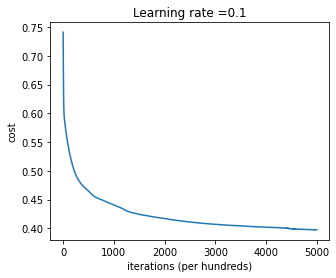

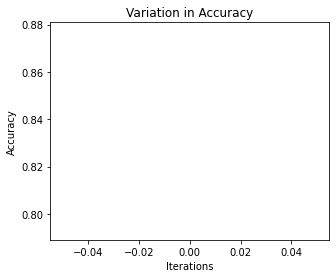

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [24]:
inputLayer = train_x.shape[0]
evaIter = 100
#evaluateHyper(inputLayer, evaIter, train_x_np, train_y_np)

dim = [inputLayer, 5, 3, 1]
accuracyList = []

#Using the best hyperparameters after having visualised the cost functions
#Calculating accuracy on the training for many training iterations
for i in range(1):
    parameters = L_layer_model(train_x_np, train_y_np, dim, learning_rate = 0.1, num_iterations = 5000, print_cost = True, print_plot = True)
    accuracy, predictions = predict(train_x_np, train_y_np, parameters)
    accuracyList.append(accuracy)   

# plotting the variation in accuracy after many iterations
plt.plot(np.squeeze(accuracyList))
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title("Variation in Accuracy")
plt.show()

#Calculating predictions on the test set
pred_test = predict_for_test(test_x_np, parameters)
pred_test_T = pred_test.transpose()
pred_test_T = np.squeeze(pred_test_T)
pred_test_ints = [int(item) for item in pred_test_T]
print(pred_test_ints)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred_test_ints})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")